In [1]:
from sklearn.datasets import load_iris
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import pandas as pd

In [2]:
gnb = GaussianNB()
iris = load_iris()
y_pred = gnb.fit(iris.data, iris.target).predict(iris.data)

In [3]:
def load_user_cmd(filename):
    cmd = pd.read_csv(filename, header=None)
    dist_max = cmd[0].value_counts().head(50)
    dist_min = cmd[0].value_counts().tail(50)
    return cmd,dist_max,dist_min

In [4]:
def get_user_cmd_feature(cmd,dist_max,dist_min):
    features = pd.DataFrame(columns=['f' + str(i) for i in range(1,12)], index=range(150))
    for i in range(0,15000,100):
        features.loc[i/100]['f1'] = len(cmd.loc[i:i+100].drop_duplicates())
        features.loc[i/100]['f2'] = len(pd.concat([cmd.loc[i:i+100].head(10),pd.DataFrame(dist_max.index)]).drop_duplicates())
        features.loc[i/100]['f3'] = len(pd.concat([cmd.loc[i:i+100].tail(10),pd.DataFrame(dist_min.index)]).drop_duplicates())
        features.loc[i/100]['f4'] = len(cmd.loc[i:i+100][cmd.loc[i:i+100][0] == 'chmod'])
        features.loc[i/100]['f5'] = len(cmd.loc[i:i+100][cmd.loc[i:i+100][0] == 'history'])
        features.loc[i/100]['f6'] = len(cmd.loc[i:i+100][cmd.loc[i:i+100][0] == 'kill'])
        features.loc[i/100]['f7'] = len(cmd.loc[i:i+100][cmd.loc[i:i+100][0] == 'killall'])
        features.loc[i/100]['f8'] = len(cmd.loc[i:i+100][cmd.loc[i:i+100][0] == 'rmdir'])
        features.loc[i/100]['f9'] = len(cmd.loc[i:i+100][cmd.loc[i:i+100][0] == 'rm'])
        features.loc[i/100]['f10'] = len(cmd.loc[i:i+100][cmd.loc[i:i+100][0] == 'vim'])
        features.loc[i/100]['f11'] = len(cmd.loc[i:i+100][cmd.loc[i:i+100][0] == 'mysqladmin'])
    return features

In [5]:
def get_label(filename, indice):
    labels = np.loadtxt(filename)
    label = np.r_[np.zeros(50),labels[:,indice-1]]
    return label

In [6]:
user_cmd,user_cmd_dist_max,user_cmd_dist_min = load_user_cmd('./数据集/masquerade/User2')
features = get_user_cmd_feature(user_cmd,user_cmd_dist_max,user_cmd_dist_min)
label = get_label("./数据集/masquerade/labels.txt", 2)
features['label'] = label.astype('int')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features[['f1','f2','f3']],features['label'])
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(features[features.columns[:-1]],features['label'])

In [8]:
gnb = GaussianNB()
gnb.fit(X_train_all, y_train_all)
gnb.score(X_test_all, y_test_all)

0.9736842105263158

In [9]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

1.0

之前对于webshell的检测是是基于调用系统函数的生成的序列向量作为特征输入来进行检测的，现在我们基于文本内容来进行webshell的检测。检测方法是收集有关webshell的黑样本，和正常wordpress的白样本，抽取每个页面中的opcode，然后以2-gram方式进行特征提取，所有的黑样本和白样本抽取出的单词生成一个语料库，再使用tfidf解析成向量，送入模型，进行训练。

同时，我们可以抽取每个php文件所具有的函数名和字符串常量，作为语料库使用1-gram进行训练。

可参考：https://zhuanlan.zhihu.com/p/48061132

In [10]:
import subprocess
import re
import glob
import numpy as np
import pandas as pd

def extract_php_opcode(path):
    try:
        fileList = glob.glob(path + '*.php')
        tokensList = []
        for file in fileList:
            output = subprocess.check_output(['php', '-dvld.active=1',
                                         '-dvld.execute=0', file],
                                        stderr=subprocess.STDOUT)
            output = str(output).replace("b'", '')
            tokens = re.findall(r'\s(\b[A-Z_]+\b)\s', output)
            tokens = [word for word in tokens if len(word)>1]
            tokensList.append(' '.join(tokens))
        return tokensList
    except:
        return ''
    
def extract_php_function_and_variables(path):
    try:
        fileList = glob.glob(path + '*.php')
        tokensList = []
        for file in fileList:
            output = open(file, 'rb').read()
            output = str(output).replace("b'", '')
            tokens = re.findall(r'\b\w+\b', output)
            tokens = [word for word in tokens if len(word)>1]
            tokensList.append(' '.join(tokens))
        return tokensList
    except:
        return ''

In [11]:
tokensList1_white = extract_php_opcode('./数据集/PHP-WEBSHELL/white/*/')
label_white = [0] * len(tokensList1_white)
tokensList1_black = extract_php_opcode('./数据集/PHP-WEBSHELL/black/xiaoma/')
label_black = [1] * len(tokensList1_black)
tokensList1 = np.concatenate((tokensList1_white, tokensList1_black))
label = label_white + label_black

In [12]:
tokensList2_white = extract_php_function_and_variables('./数据集/PHP-WEBSHELL/white/*/')
tokensList2_black = extract_php_function_and_variables('./数据集/PHP-WEBSHELL/black/xiaoma/')
tokensList2 = np.concatenate((tokensList2_white, tokensList2_black))

In [13]:
tfidf1 = TfidfVectorizer(ngram_range=(1,2))
X1 = tfidf1.fit_transform(tokensList1).toarray()
tfidf2 = TfidfVectorizer(ngram_range=(1,2))
X2 = tfidf2.fit_transform(tokensList2).toarray()
y = label

X1_train, X1_test, y_train, y_test = train_test_split(X1, y)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y)

In [14]:
gnb1 = GaussianNB()
gnb1.fit(X1_train, y_train)
gnb1.score(X1_test, y_test)

0.5555555555555556

In [15]:
gnb2 = GaussianNB()
gnb2.fit(X2_train, y_train)
gnb2.score(X2_test, y_test)

0.9444444444444444

In [16]:
rfc1 = RandomForestClassifier(n_estimators=50)
rfc1.fit(X1_train, y_train)
rfc1.score(X1_test, y_test)

0.7222222222222222

In [17]:
rfc2 = RandomForestClassifier(n_estimators=50)
rfc2.fit(X2_train, y_train)
rfc2.score(X2_test, y_test)

0.8888888888888888

In [18]:
cross_val_score(rfc1, X1, y, cv=10).mean()

0.9458333333333334

In [19]:
cross_val_score(rfc2, X2, y, cv=10).mean()

0.9107142857142858

对于域名检测算法DGA的检测，因该算法会常用于僵尸网络中，用于逃避安全研究人员的追踪。这里我们使用cryptolocker和post-tovar-goz家族的DGA域名，同时使用2-gram文本检测方法。

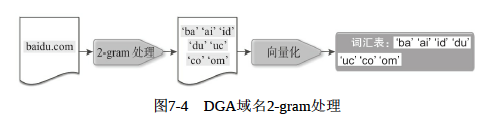

In [20]:
def load_and_get_features1(filename, white=True, black=False):
    dga = pd.read_csv(filename, header=None)
    if white:
        features_white = dga[1].str.replace('.', ' ').tolist()
        return features_white
    if black:
        features_black = dga[0].str.replace('.', ' ').tolist()
        return features_black
    
def load_and_get_features2(filename, white=True, black=False):
    dga = pd.read_csv(filename, header=None)
    if white:
        features_white = dga[1].str.split('.').str.join('').str.join(' ').tolist()
        return features_white
    if black:
        features_black = dga[0].str.split('.').str.join('').str.join(' ').tolist()
        return features_black

In [21]:
features1_white = load_and_get_features1('./数据集/DGA/top-1000.csv', white=True)
features1_black1 = load_and_get_features1('./数据集/DGA/dga-cryptolocke-1000.txt', white=False, black=True)
features1_black2 = load_and_get_features1('./数据集/DGA/dga-post-tovar-goz-1000.txt', white=False, black=True)

In [22]:
features2_white = load_and_get_features2('./数据集/DGA/top-1000.csv', white=True)
features2_black1 = load_and_get_features2('./数据集/DGA/dga-cryptolocke-1000.txt', white=False, black=True)
features2_black2 = load_and_get_features2('./数据集/DGA/dga-post-tovar-goz-1000.txt', white=False, black=True)

In [23]:
features1 = np.concatenate((features1_white, features1_black1, features1_black2))
features2 = np.concatenate((features2_white, features2_black1, features2_black2))
label_white = [0] * len(features1_white)
label_black1 = [1] * len(features1_black1)
label_black2 = [1] * len(features1_black2)
label = label_white + label_black1 + label_black2

In [24]:
tfidf1 = TfidfVectorizer(ngram_range=(1,2))
countvec1 = CountVectorizer(ngram_range=(1,2))
X_tfidf1 = tfidf1.fit_transform(features1).toarray()
X_countvec1 = countvec1.fit_transform(features1).toarray()

tfidf2 = TfidfVectorizer(ngram_range=(2,2), token_pattern='\w')
countvec2 = CountVectorizer(ngram_range=(2,2), token_pattern='\w+')
X_tfidf2 = tfidf2.fit_transform(features2).toarray()
X_countvec2 = countvec2.fit_transform(features2).toarray()
y = label

X_train_tfidf1, X_test_tfidf1, y_train, y_test = train_test_split(X_tfidf1, y)
X_train_countvec1, X_test_countvec1 = train_test_split(X_countvec1)
X_train_tfidf2, X_test_tfidf2 = train_test_split(X_tfidf2)
X_train_countvec2, X_test_countvec2 = train_test_split(X_countvec2)

In [25]:
gnb_tfidf1 = GaussianNB()
gnb_tfidf1.fit(X_train_tfidf1, y_train)
gnb_tfidf1.score(X_test_tfidf1, y_test)

0.324

In [26]:
gnb_tfidf2 = GaussianNB()
gnb_tfidf2.fit(X_train_tfidf2, y_train)
gnb_tfidf2.score(X_test_tfidf2, y_test)

0.4266666666666667

In [27]:
cross_val_score(gnb_tfidf1,X_tfidf1,y,cv=10).mean()

0.35300000000000004

In [28]:
cross_val_score(gnb_tfidf2,X_tfidf2,y,cv=10).mean()

0.9303333333333335

In [29]:
gnb_countvec1 = GaussianNB()
gnb_countvec1.fit(X_train_countvec1, y_train)
gnb_countvec1.score(X_test_countvec1, y_test)

0.336

In [30]:
gnb_countvec2 = GaussianNB()
gnb_countvec2.fit(X_train_countvec2, y_train)
gnb_countvec2.score(X_test_countvec2, y_test)

0.408

In [31]:
cross_val_score(gnb_countvec1,X_countvec1,y,cv=10).mean()

0.35300000000000004

In [32]:
cross_val_score(gnb_countvec2,X_countvec2,y,cv=10).mean()

0.9303333333333335

对于apache的ddos攻击，我们仍然使用KDD99数据集，具体实施流程如下：

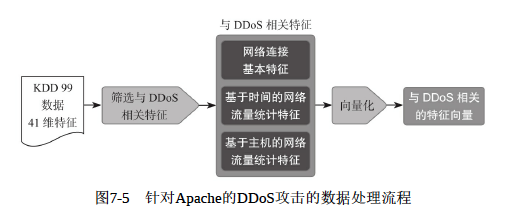

其中，与DDOS相关的特征主要有：

* 网络连接基本特征

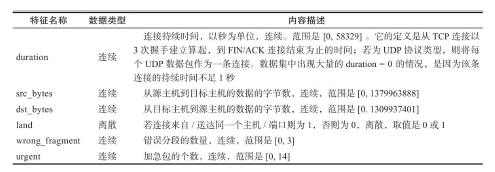

* 基于时间的网络流量统计特征

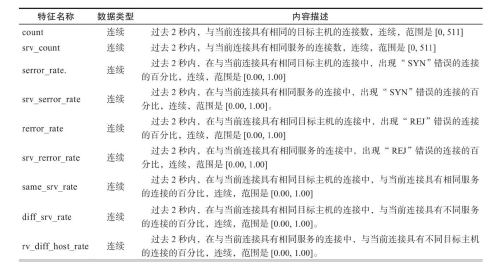

* 基于主机的网络流量统计特征

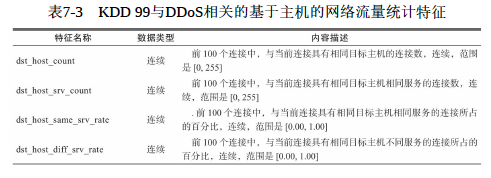
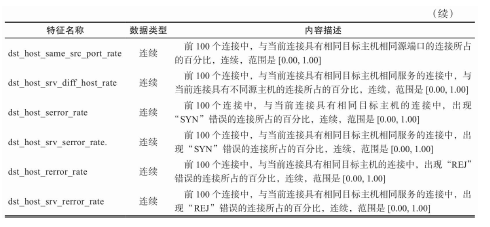

In [33]:
def load_and_get_features_label(filename, train=True, test=False):
    if train:
        kdd99_train = pd.read_csv(filename, header=None)
        ddos_train = kdd99_train[kdd99_train[41].str.contains('normal|apache2', regex=True)]
        ddos_train = ddos_train[ddos_train[2] == 'http']
        features_train = pd.concat([ddos_train[0],ddos_train[ddos_train.columns[4:8]],ddos_train[ddos_train.columns[31:40]]], axis=1)
        label = ddos_train[ddos_train.columns[-1]]
        return features_train,label
    if test:
        kdd99_test = pd.read_csv(filename, header=None)
        features_test = pd.concat([kdd99_test[0],kdd99_test[kdd99_test.columns[4:8]],kdd99_test[kdd99_test.columns[31:40]]], axis=1)
        return features_test

In [34]:
features_train, label = load_and_get_features_label('./数据集/KDD 99/kddcup.data.corrected')

In [35]:
X_train, X_val, y_train, y_val = train_test_split(features_train, label)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_val, y_val)

1.0

In [36]:
cross_val_score(gnb, features_train, label, cv=10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

而对于验证码的识别，现在即使比较复杂的验证码，也能很好地识别出来，所以现在很多开始采用滑动块验证和google的机器人验证。这里我们模拟使用MNIST的数据集来进行验证码识别，实际情况要远高于这个难度。而MNIST默认train有60000个样本，test有10000个样本。

事实上NB算法在非黑即白的二分类问题上使用广泛，但是在多分类问题上的表现确实不如其他算法。

In [76]:
from keras.datasets import mnist

In [77]:
mnist_train, mnist_test = mnist.load_data()

In [80]:
X_train = mnist_train[0].reshape(60000, 28 * 28)
X_test = mnist_test[0].reshape(10000, 28 * 28)

In [81]:
gnb = GaussianNB()
gnb.fit(X_train, mnist_train[1])
gnb.score(X_test, mnist_test[1])

0.5558

In [82]:
cross_val_score(gnb, X_train, mnist_train[1], cv=10, scoring='accuracy')

array([0.56893107, 0.55039147, 0.55974004, 0.57883333, 0.56233333,
       0.5584264 , 0.55992665, 0.54725788, 0.56494914, 0.57288192])